# Core concepts

Below I define few critical concepts for Orcapod.

* `Data` -- In Orcapod, smallest unit of `data` is a single `file`. Unlike many other computation pipeline system, Orcapod pipeline in principle does **not** operate on `data` that's not a file. In other words, `Oracpod` pipeline will **not** pass a data in memory from one node to another. Consequently, all operations and processing in Orcapod pipeline revolves around `file` (NOTE: this is a particularly strong/restrictive version of Oracpod pipeline. We may consider extending data to things like environment variable and command line arguments)
* `Pathset` -- a unit of data that can be passed into a pod. A `pathset` consists of a file, a directory, or a collection of one or more file and directories.
* `Packet` -- a single concrete instance of key-value pair, mapping packet key to a single `pathset`.
* `Stream` -- a series of one or more `packets` flowing from a `data producer` to a `data consumer`. In a directed acyclic graph represneing an Orcapod `pipeline`, a `stream` corresponds to a *directed* edge connecting from a data source into a `data consumer` (e.g., `pod`)
* `Data producer` and `data consumer` -- in the Orcapod data pipeline, data (in form of `packet` of data flowing inside a `stream`) flows from a `data producer` to a `data consumer`. Consequentially, a `data consumer` may in turn act as a `data producer` downstream
* `Data source` -- Root level `data producer` (that is, the data originates from this `data producer` and it is not a `data consumer` of any stream). Typically `data source` is tied to a data storage, although you could have *procedural* `data source` where data packets are produced programatically.
* `Tag` -- each `Packet` in a stream *may be* associated with a `tag` that helps to assign semantic identity to the particular `packet`. For example, a data `packet` for an experimental data may be associated with a `tag` of session ID. Note that while `tag` provides a convenient and often meaningful ways of identifying and referring to specific packet within a stream, it should **not** be considered to be the defining identity of the `packet`. Identity of the `packet` is strictly determined by the exact data content of the `packet`, and not by how you refer to it. Consequently, it may be that two packets with an identical content (and thus shared identity) are associated with distinct `tags` in a `stream`. Conversely, an identical `tag` may be associated with two distinct `packets` in a stream.  Typically, one would associate a unique `tag` for each packet in the stream.
* `Operation` -- A *node* in the directed acyclic graph representing an Orcapod `pipeline`, corresponding to a step of data processing/transformation/computation. An `Operation` receives can be classified into either a `mapper` or a `pod` based on their role in `data provenance`.
* `Mapper` -- A class of `operation` that does **not** result in creation/alteration of a new data -- that is, `operation` does **not** every create or modify a file *content*. More specifically, `Mapper` operation can not produce a path that was not already present in the input streams to the `mapper`. This feature ensures that a `mapper` is fundamentally not involved in the reproducibility of computation. Consequently, `mapper` information is not necessary for the maintenance of proper `data provenance` in a tree of computation. However, `mapper` plays critical role in the actual execution of a data pipeline, determining which data `packet` will be fed into operations in the pipeline directed acyclic graph (DAG). Note that as long as it doesn't modify the content of any file, a `mapper` may inspect the content of any file in a `packet` it receives and alter its behavior based on the content of the file. In other words, `mapper` may alter what data file(s) gets passed around without changing/creating any file based on a rule that depends on `tag`, `packet` key (`argument` name) and/or file content.
* `Pod` (e.g. FunctionPod) -- fundamental unit of computation in Orcapod. `Pod` is the only class of `operation` that may create a new file. Critically, when operating within an Orcapod `pipeline`, a `pod` will **not** receive the `tag` information. Rather, `pod` must strictly operate on a single `packet`. An ideal `pod` will have completely deterministic behavior that only depends on the `packet` identity (that is, packet keys and `pathset` contents).

# What is Orcabrdige?

`Orcabridge` provide prototypal implementation of the above-defined key concepts in `orcapod`, with particular focus given to `stream`, `packet`, `tag`, `operation` (`pod` and `mapper`). This package provides the reference implementation of both synchronous and asynchronous `streams` as a sequence of `packets` associated with a `tag`. 

### Key limitations
Being a very basic reference implementation with a goal of serving as a playground for conceptual and algorithmic development, there are a few notable limitations in `orcabridge`, lacking some important features that would be found in the full implementation of `orcapod`.

* Limited `pathset` -- Only a very rudimentary implementation of a `pathset` can be found, where a typical `packet` would be a simple key-value pair where the value is a single file path. 
* `FunctionPod` in place of `pod` -- A ideal `pod` will represent a completely reproducible unit of computation with strict dependence on the input `packet` to the `pod`. However, in `orcabridge` is equivalated to a Python function -- even more specifically, the name assigned to the Python function. In otherwords, two `FunctionPods` are considered identical if they share the same function name. Quite obviously this is a gross simplification that can be trivially violated. However, for the intended purpose of `orcabridge`, this rather simplistic implementation/definition of `pod` should suffice to test all features in the `pipeline`. Consequently, to ensure that the pipeline operates as expected, **do not use the same name for two distinct functions**. Doing so will break the fundamental assumption of `FunctionPod` and lead to completely erradic behavior. On the other hand, it is ok to have one or more name used to refer to an identical function.
* Different pipeline DAG defintion -- In `orcapod` the directed acyclic graph (DAG) for the `pipeline` should be defined using YAML file (or less frequently using API on `pipeline` struct in the Rust library). In `orcabridge` you will find that a `pipeline` DAG is defined dynamically through a series of application of `operation`. This is very much akin to how some DAG-based neural network library like TensorFlow defines a computation graph. While this works well for simple examples, it is rather difficult to track changes to the pipeline defined dynamically/programmatically using version control system. Since *how* you define the pipeline DAG is strictly speaking an orthogonal problem to the everything else that concerns the operation of the `pipeline`, no effort will be given to align the DAG definition in `orcabridge` and `orcapod`.
* Limited usage of a `stream` -- Currently `orcabrdige` only support single producer single consumer (SCSP) `stream`x, whereas in `orcapod`, `stream` should support single producer multiple consumer (SPMC) paradigm. This can be somewhat overcome by using `Duplicator` mapper but this is fundamentally less efficient then pipeline implementation based on SPMC.

# Using Orcabridge

Below we explore the usage of `orcabridge` package, enumerating the core components.

## Working with streams

`Stream` is fundamental to Orcapod datapipeline, representing *edges* in a directed acyclic graph (DAG) of an Orcapod pipeline. `Stream` is best thought of as a flowing stream of `packets` -- a unit of data in Oracpod. A `packet` is essentially a ditionary mapping argument names to a `pathset` (that is, one or more files with arbitrary nesting). Ultimately, a pod will receive and work on the `packet`, looking up the pathset that matches the expected argument names defined as the inputs into the pod. Before we explore creating and using `pod`, we will create a very basic `stream` called `GlobStream`, sourcing from a directory. A packet is formed for each file that matches the specified *glob* pattern.

In [8]:
from orcabridge.file import GlobStream

Let's create a stream out of all `*.txt` files found in the folder `examples/dataset1`

In [19]:
ls ./examples/dataset1

day1.txt*  day2.txt*  day3.txt*  day4.txt*


In [16]:
dataset1_stream = GlobStream('txt_file', './examples/dataset1', '*.txt')

Any `stream` can act as an iterator over tagged packets.

In [17]:
for tag, packet in dataset1_stream:
    print(f'Packet {packet} with tag {tag}')

Packet {'txt_file': PosixPath('examples/dataset1/day1.txt')} with tag {'file_name': 'day1'}
Packet {'txt_file': PosixPath('examples/dataset1/day2.txt')} with tag {'file_name': 'day2'}
Packet {'txt_file': PosixPath('examples/dataset1/day3.txt')} with tag {'file_name': 'day3'}
Packet {'txt_file': PosixPath('examples/dataset1/day4.txt')} with tag {'file_name': 'day4'}


A few things to note. When creating the `GlobStream` we pass in the argument name to be associated with the `pathset` matching our glob pattern (`*.txt` in this case). By default, the `GlobStream` tags each packet with a key of `file_name` and value of the name of the file that was matched (minus the file extension). This behavior can be easily changed by passing in a custom function for tag generation at the time of `GlobStream` creation.

In [25]:
from pathlib import Path
dataset1_stream_custom = GlobStream('data', './examples/dataset1', '*.txt', tag_function=lambda x: {'date': Path(x).stem})

In [27]:
for tag, packet in dataset1_stream_custom:
    print(f'Packet {packet} with tag {tag}')

Packet {'data': PosixPath('examples/dataset1/day1.txt')} with tag {'date': 'day1'}
Packet {'data': PosixPath('examples/dataset1/day2.txt')} with tag {'date': 'day2'}
Packet {'data': PosixPath('examples/dataset1/day3.txt')} with tag {'date': 'day3'}
Packet {'data': PosixPath('examples/dataset1/day4.txt')} with tag {'date': 'day4'}


Custom tag function would allow one to extract information useful in controlling the flow of the data pipeline from the file path or even the file content. We will return to this a bit later.

In general, a packet is generated and starts flowing in `stream` **only** when you ask for it by iterating through the elements. This allows for a series of streams and pods to be chained together without immediately invoking any computation.

Let's go ahead and load another stream from a folder containing multiple `*.bin` files, supposedly containing data collected on different days.

In [28]:
dataset2_stream = GlobStream('bin_data', './examples/dataset2', '*.bin')

for tag, packet in dataset2_stream:
    print(f'Packet {packet} with tag {tag}')

Packet {'bin_data': PosixPath('examples/dataset2/session_day1.bin')} with tag {'file_name': 'session_day1'}
Packet {'bin_data': PosixPath('examples/dataset2/session_day3.bin')} with tag {'file_name': 'session_day3'}
Packet {'bin_data': PosixPath('examples/dataset2/session_day4.bin')} with tag {'file_name': 'session_day4'}
Packet {'bin_data': PosixPath('examples/dataset2/session_day5.bin')} with tag {'file_name': 'session_day5'}


Now we have two streams to work with, let's explore how we can manipulate/control the flow of streams using `operations` and, specifically, `mapper` operations.

## Manipulating streams with `operations`

As defined ealier in the [core concepts](#core-concepts), we refer to any computation/transformation that works on stream(s) as `operations` in the pipeline. If the Orcapod pipeline were to be viewed as a DAG, the `streams` would be the edges connecting *nodes* that are the `operations`. 

`Operations` can be divided into two categories based on their roles in the processing and manipulating streams. `Mappers` are `operations` that controls and alter the streams but *without generating or modifying new data files*. As we will see shortly, `mappers` work to alter the stream by alterning packet tags and/or packet content, but critically will never create or modify new files that were not already present somewhere in the stream feeding into the `mapper` node. While this might sound like an unnecessary restriction on what `mappers` can do, we will see that this property guarantees that *mappers can not ever alter the reproducibility of computational chains*.

The second category of `operations` are called the `pods`, and as you may have guessed, these operations are **allowed to generate and flow new files into the streams**. In fact, `pods` are the only operations that can introduce new files into the stream. Consequently, stream `sources` such as `GlobFileSource` we saw earlier are also a type of pods, that's special in that it takes no input streams!

We will explore pods in great detail later. First let's get to know `mappers`.

### Controling data streams with `Mappers`

Once you have created `source` from which streams can be formed, you can alter the stream by applying various `mappers`. More precisely, a `mapper` can work on tags and/or packets.

### Map keys
Likey one of the most common mapper operation to be found in Orcapod pipeline is `MapKeys` mapper. As the name implies, it let's you alter the keys (argument names) found in the `packet`.

In [33]:
from orcabridge.mapper import MapKeys

print("Before mapping:")
for tag, packet in dataset1_stream:
    print(f'Packet {packet} with tag {tag}')


# create a new stream mapping packet keys 'txt_file' to 'content'
key_mapper = MapKeys(key_map={'txt_file': 'content'})

print("After mapping:")
for tag, packet in key_mapper(dataset1_stream):
    print(f'Mapped Packet {packet} with tag {tag}')


Before mapping:
Packet {'txt_file': PosixPath('examples/dataset1/day1.txt')} with tag {'file_name': 'day1'}
Packet {'txt_file': PosixPath('examples/dataset1/day2.txt')} with tag {'file_name': 'day2'}
Packet {'txt_file': PosixPath('examples/dataset1/day3.txt')} with tag {'file_name': 'day3'}
Packet {'txt_file': PosixPath('examples/dataset1/day4.txt')} with tag {'file_name': 'day4'}
After mapping:
Mapped Packet {'content': PosixPath('examples/dataset1/day1.txt')} with tag {'file_name': 'day1'}
Mapped Packet {'content': PosixPath('examples/dataset1/day2.txt')} with tag {'file_name': 'day2'}
Mapped Packet {'content': PosixPath('examples/dataset1/day3.txt')} with tag {'file_name': 'day3'}
Mapped Packet {'content': PosixPath('examples/dataset1/day4.txt')} with tag {'file_name': 'day4'}


You'd notice that for each packet, the key `txt_file` was replaced with `content` without altering the pointed `path` or the associated tag. As the keys of the packets will be used as the name of arguments when invoking pods on a stream, we will see that `MapKeys` are commonly used to *map* the correct path to the argument.

### Map tags
As we have already seen, each packet in the stream is associated with a tag, often derived from the data source. In the case of `GlobFileSource`, the tags are by default the name of the file that formed the packet. These tags are used to *transiently* identify the packet and will be used when matching packets across multiple streams (as we will see shortly in `Join` operation). You can manipulate the tags using `MapTags` operation, much like `MapKeys` but operating on the tags for each packaet under a uniform renaming rule.

In [39]:
from orcabridge.mapper import MapTags
tag_mapper = MapTags(tag_map={'file_name': 'day'})

for tag, packet in tag_mapper(dataset1_stream):
    print(tag, packet)

{'day': 'day1'} {'txt_file': PosixPath('examples/dataset1/day1.txt')}
{'day': 'day2'} {'txt_file': PosixPath('examples/dataset1/day2.txt')}
{'day': 'day3'} {'txt_file': PosixPath('examples/dataset1/day3.txt')}
{'day': 'day4'} {'txt_file': PosixPath('examples/dataset1/day4.txt')}


### Chaining operations

### Joining multiple streams into a single stream
You can combine multiple streams into one by using `Join` operation, matching packets from each constitutent stream based on matching tag. If tags from two streams have shared key, the value must be identical for all shared keys in order for the two packets to be matched and used to create a new merged packet.

In [11]:
joined_stream = Join(table_stream, table_stream2)

for tag, packet in joined_stream:
    print(tag, packet)

{'animal_id': 1, 'subject_id': 1} {'data1': '/path/to/data1', 'data2': '/path/to/data2', 'data3': '/path/to/data9', 'data4': '/path/to/data30'}
{'animal_id': 1, 'subject_id': 3} {'data1': '/path/to/data1', 'data2': '/path/to/data2', 'data3': '/path/to/data10', 'data4': '/path/to/data62'}
{'animal_id': 1, 'subject_id': 5} {'data1': '/path/to/data1', 'data2': '/path/to/data2', 'data3': '/path/to/data9', 'data4': '/path/to/data10'}
{'animal_id': 2, 'subject_id': 1} {'data1': '/path/to/data3', 'data2': '/path/to/data4', 'data3': '/path/to/data9', 'data4': '/path/to/data30'}
{'animal_id': 2, 'subject_id': 3} {'data1': '/path/to/data3', 'data2': '/path/to/data4', 'data3': '/path/to/data10', 'data4': '/path/to/data62'}
{'animal_id': 2, 'subject_id': 5} {'data1': '/path/to/data3', 'data2': '/path/to/data4', 'data3': '/path/to/data9', 'data4': '/path/to/data10'}
{'animal_id': 3, 'subject_id': 1} {'data1': '/path/to/data5', 'data2': '/path/to/data6', 'data3': '/path/to/data9', 'data4': '/path/to

Above, you see that every single possible combination of the two streams are found because the two streams did **not** share any common tag keys, and therefore performed full multiplexing. You can rename one of the tag keys so that they can be matched.

In [12]:
renamed_stream = MapTags(table_stream2, tag_map={'subject_id': 'animal_id'})
joined_stream = Join(table_stream, renamed_stream)

for tag, packet in joined_stream:
    print(tag, packet)


{'animal_id': 1} {'data1': '/path/to/data1', 'data2': '/path/to/data2', 'data3': '/path/to/data9', 'data4': '/path/to/data30'}
{'animal_id': 3} {'data1': '/path/to/data5', 'data2': '/path/to/data6', 'data3': '/path/to/data10', 'data4': '/path/to/data62'}


## Applying function on a stream

Streams are not too useful if it can be easily operated on. You can create a `FunctionPod` by wrapping a plain Python function, and the resulting function pod can operate on a stream, applying the wrapped function on each packet, one at a time. Note that the function does **not** see the tag associated with the packet  -- function should strictly operate using information in the packet.

In [13]:
def process_data(data1, data2):
    print('\n\nFunction was called!')
    print(f'Processing data1 from {data1}')
    print(f'Processing data2 from {data2}')
    return '/path/to/new/output'


# create a function pod
function_pod = FunctionPod(process_data, output_keys=['output_path'])

Once function pod is available, you can execute it on any compatible stream

In [14]:
# apply the function pod on a stream
processed_stream = function_pod(table_stream)

for tag, packet in processed_stream:
    print(tag, packet)
    



Function was called!
Processing data1 from /path/to/data1
Processing data2 from /path/to/data2
{'animal_id': 1} {'output_path': '/path/to/new/output'}


Function was called!
Processing data1 from /path/to/data3
Processing data2 from /path/to/data4
{'animal_id': 2} {'output_path': '/path/to/new/output'}


Function was called!
Processing data1 from /path/to/data5
Processing data2 from /path/to/data6
{'animal_id': 3} {'output_path': '/path/to/new/output'}


Function was called!
Processing data1 from /path/to/data7
Processing data2 from /path/to/data8
{'animal_id': 4} {'output_path': '/path/to/new/output'}


In [15]:
# map second table stream to match the expected packet keys
mapped_stream = MapKeys(table_stream2, key_map={'data3': 'data1', 'data4': 'data2'})

# apply the function pod on the mapped stream
processed_stream2 = function_pod(mapped_stream)

for tag, packet in processed_stream2:
    print(tag, packet)



Function was called!
Processing data1 from /path/to/data9
Processing data2 from /path/to/data30
{'subject_id': 1} {'output_path': '/path/to/new/output'}


Function was called!
Processing data1 from /path/to/data10
Processing data2 from /path/to/data62
{'subject_id': 3} {'output_path': '/path/to/new/output'}


Function was called!
Processing data1 from /path/to/data9
Processing data2 from /path/to/data10
{'subject_id': 5} {'output_path': '/path/to/new/output'}


Notice that function pod operates fine as long as the incoming packet has compatible keys with the function. As tags are not passed into the function pod, the fact that above two examples had distinct types of tags does not matter.

## Using storage-backed function pod

Althought the vanilla function pod `FunctionPod` illustrates the core principle of a function pod, they lack many useful features such as output storage and memoization. To use such features, you have to use a storaged-backed function pod. Here we are going to explore using DJ table-backed function pod called `DJFunctionPod`

In [16]:
from orcabridge.dj.pod import DJFunctionPod

A key difference between `DJFunctionPod` and `FunctionPod` is that the former is table-backed and therefore can store its output in a database table. For this reason, when instantiating a `DJFunctionPod`, you have to supply both a DataJoint schema and a valid table name

In [17]:
dj_fpod = DJFunctionPod(process_data, output_keys=['output_path'], schema=schema, name='processed_data')

Once created, you can use DJ function pod just like an ordinary function pod. However, it is keeping track and storing all computation outputs behind the scenes.

In [18]:
# apply the function pod on a stream
processed_stream = dj_fpod(table_stream)

for tag, packet in processed_stream:
    print(tag, packet)
    

{'animal_id': 1} {'output_path': '/path/to/new/output'}
{'animal_id': 2} {'output_path': '/path/to/new/output'}
{'animal_id': 3} {'output_path': '/path/to/new/output'}
{'animal_id': 4} {'output_path': '/path/to/new/output'}


You can appreciate the memoization if you run same computation twice

In [19]:
# Calling the function pod on the same stream
processed_stream = dj_fpod(table_stream)

for tag, packet in processed_stream:
    print(tag, packet)
    

{'animal_id': 1} {'output_path': '/path/to/new/output'}
{'animal_id': 2} {'output_path': '/path/to/new/output'}
{'animal_id': 3} {'output_path': '/path/to/new/output'}
{'animal_id': 4} {'output_path': '/path/to/new/output'}


Notice that when called the second time, function was actually **not** invoked. Rather, the stored or *memoized* result from the previous invocation was returned.

As with regular function pod, you can run the pod on a stream with different tags (but with compatible packet keys)

In [21]:
mapped_stream = MapKeys(table_stream2, key_map={'data3': 'data1', 'data4': 'data2'})

for tag, packet in dj_fpod(mapped_stream):
    print(tag, packet)



Function was called!
Processing data1 from /path/to/data9
Processing data2 from /path/to/data30
{'subject_id': 1} {'output_path': '/path/to/new/output'}


Function was called!
Processing data1 from /path/to/data10
Processing data2 from /path/to/data62
{'subject_id': 3} {'output_path': '/path/to/new/output'}


Function was called!
Processing data1 from /path/to/data9
Processing data2 from /path/to/data10
{'subject_id': 5} {'output_path': '/path/to/new/output'}


Stroage-backed function pod can serve as a stream, thus sourcing data to other operations and pods. In this case, function pod returns all stored past results.

In [22]:
for tag, packet in dj_fpod:
    print(tag, packet)


{'processed_data_uuid': UUID('115b2b23-3262-278e-2b9d-350d484e68b6')} {'input_files': 'data1:/path/to/data1,data2:/path/to/data2', 'output_path': '/path/to/new/output'}
{'processed_data_uuid': UUID('2c54462e-568a-196b-8559-65621e839c9a')} {'input_files': 'data1:/path/to/data5,data2:/path/to/data6', 'output_path': '/path/to/new/output'}
{'processed_data_uuid': UUID('4de4316d-19d7-f92f-a6c2-010e388f39b3')} {'input_files': 'data1:/path/to/data9,data2:/path/to/data30', 'output_path': '/path/to/new/output'}
{'processed_data_uuid': UUID('72c339d7-150c-fb7c-233e-7a8e0e030a63')} {'input_files': 'data1:/path/to/data3,data2:/path/to/data4', 'output_path': '/path/to/new/output'}
{'processed_data_uuid': UUID('93f27a8c-0a9d-d18a-f2ca-6e4a6a7ce495')} {'input_files': 'data1:/path/to/data7,data2:/path/to/data8', 'output_path': '/path/to/new/output'}
{'processed_data_uuid': UUID('a3a151fa-330a-1cf3-f5fa-0da62e00dd83')} {'input_files': 'data1:/path/to/data9,data2:/path/to/data10', 'output_path': '/path/

In [24]:
def parse_data(source_data):
    print('\n\nFunction was called!')
    print(f'Parsing data from {source_data}')
    return '/parsed/output/' + (source_data.split("/")[-1]) + '_parsed'

dj_fpod2 = DJFunctionPod(parse_data, output_keys=['parsed_path'], schema=schema, name='parsed_data')

for tag, packet, in dj_fpod2(MapKeys(dj_fpod, key_map={'output_path': 'source_data'})):
    print(tag, packet)



Function was called!
Parsing data from /path/to/new/output
{'processed_data_uuid': UUID('115b2b23-3262-278e-2b9d-350d484e68b6')} {'parsed_path': '/parsed/output/output_parsed'}
{'processed_data_uuid': UUID('2c54462e-568a-196b-8559-65621e839c9a')} {'parsed_path': '/parsed/output/output_parsed'}
{'processed_data_uuid': UUID('4de4316d-19d7-f92f-a6c2-010e388f39b3')} {'parsed_path': '/parsed/output/output_parsed'}
{'processed_data_uuid': UUID('72c339d7-150c-fb7c-233e-7a8e0e030a63')} {'parsed_path': '/parsed/output/output_parsed'}
{'processed_data_uuid': UUID('93f27a8c-0a9d-d18a-f2ca-6e4a6a7ce495')} {'parsed_path': '/parsed/output/output_parsed'}
{'processed_data_uuid': UUID('a3a151fa-330a-1cf3-f5fa-0da62e00dd83')} {'parsed_path': '/parsed/output/output_parsed'}
{'processed_data_uuid': UUID('a7e4bd24-ea13-8628-9111-c3b289079337')} {'parsed_path': '/parsed/output/output_parsed'}


It's worth noting that pod execution are stored/memoized based on the content of the packet with no reliance on the tag. Therefore, if two or more packets with distinct tags but with identical contents are processed, only the first instance will be computed and the subsequent ones return the memoized values, saving on computation. In the above example, the function `parse_data` was called only once as all invocations involved identical packet as an input.

Chaining together DJ-backed function pods do **not** result in foreign-key dependency to be formed between the two tables. The two data-backing tables will remain independent of each other. We will soon see how you can automatically create a DJ relational pipeline *representation* of a pipeline formed from streams, operations and pods, allowing for query to be performed using DataJoint query engine.

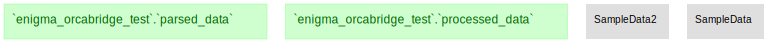

In [25]:
dj.Diagram(schema)